In [1]:
import re, json
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 데이터 불러오기

In [2]:
PATH = '/dataset/'

In [3]:
TRAIN_DATA = 'clean_dataset2.csv'

In [4]:
total_df = pd.read_csv(PATH+TRAIN_DATA)

In [5]:
total_df

,Store,Dept,Weekly_Sales,Type_A,Type_B,Type_C,Size,Year,Week,Date
0,1,1,24924.50,1,0,0,151315,2010,5,2010-02-05
1,1,1,46039.49,1,0,0,151315,2010,6,2010-02-12
2,1,1,41595.55,1,0,0,151315,2010,7,2010-02-19
3,1,1,19403.54,1,0,0,151315,2010,8,2010-02-26
4,1,1,21827.90,1,0,0,151315,2010,9,2010-03-05
...,...,...,...,...,...,...,...,...,...,...
536629,45,98,NaN,0,1,0,118221,2013,26,2013-06-28
536630,45,98,NaN,0,1,0,118221,2013,27,2013-07-05
536631,45,98,NaN,0,1,0,118221,2013,28,2013-07-12
536632,45,98,NaN,0,1,0,118221,2013,29,2013-07-19


## 데이터 split

#### [1] train-test로 나누기

* 나누는 방법은 => Weekly_Sales가 NULL인것
* 그리고 test_id 생성 : Store+Dept+Date

In [6]:
print(len(total_df))

536634


In [7]:
train_df = total_df[~total_df['Weekly_Sales'].isnull()]
test_df = total_df[total_df['Weekly_Sales'].isnull()]

train len  421570

test len :  115064

In [8]:
print(len(train_df))
print(len(test_df))

421570
115064


In [9]:
# train 필요없는 속성 = Date drop

train_df.drop('Date', axis=1, inplace=True)

/home/ai-sjjy/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:
# test 필요 없는 속성 Weekly_Sales drop
# test 필요한 속성 => ID(Store+Dept+Date) 합치기
# 그다음 Date 삭제

test_df.drop('Weekly_Sales', axis=1, inplace=True)

IDs = [str(a)+'_'+str(b)+'_'+c for a, b, c in zip(test_df['Store'].tolist(), test_df['Dept'].tolist(), test_df['Date'].tolist())]
test_df['Id'] = IDs

test_df.drop('Date', axis=1, inplace=True)

<ipython-input-10-16c91f4b8f2a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Id'] = IDs


In [11]:
test_df

,Store,Dept,Type_A,Type_B,Type_C,Size,Year,Week,Id
421570,1,1,1,0,0,151315,2012,44,1_1_2012-11-02
421571,1,1,1,0,0,151315,2012,45,1_1_2012-11-09
421572,1,1,1,0,0,151315,2012,46,1_1_2012-11-16
421573,1,1,1,0,0,151315,2012,47,1_1_2012-11-23
421574,1,1,1,0,0,151315,2012,48,1_1_2012-11-30
...,...,...,...,...,...,...,...,...,...
536629,45,98,0,1,0,118221,2013,26,45_98_2013-06-28
536630,45,98,0,1,0,118221,2013,27,45_98_2013-07-05
536631,45,98,0,1,0,118221,2013,28,45_98_2013-07-12
536632,45,98,0,1,0,118221,2013,29,45_98_2013-07-19


#### [2] train-validation으로로 나누기

In [12]:
y = train_df['Weekly_Sales']
X = train_df.drop('Weekly_Sales', axis=1)

In [13]:
from sklearn.model_selection import train_test_split # 데이터 셋 

# 방법 1
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=101)

In [14]:
print(len(train_df))
print(len(X_train))
print(len(X_val))

421570
337256
84314


## 모델링

#### [참고]

* WMAE 가중평균 절대오차
    - WMAE는 Sklearn에 정의된 메트릭 x

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor


from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score


import xgboost

In [16]:
def evaluation(model, train_x, train_y, val_x, val_y):
    cv = cross_val_score(model, train_x, train_y, cv = 10)
    y_pred = model.predict(val_x)
    cv = np.mean(cv)
    r2=r2_score(y_pred, val_y)
    mae = mean_absolute_error(y_pred, val_y)

    return cv, r2, mae

In [17]:
def show_plot(model, val_x, val_y):
    y_pred = model.predict(val_x)

    plt.scatter(val_y, y_pred)
    plt.xlabel("Price Index: $Y_i$")
    plt.ylabel("Predicted price Index: $\hat{Y}_i$")
    plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")

In [18]:
def wmae(model, val_x, val_y): #x_val, y_val
    y_pred = model.predict(val_x)
    
    weights = val_x
    #weights = val_x.IsHoliday.apply(lambda x:5 if x else 1)
    metric = np.sum(abs(np.array(val_y) - np.array(y_pred)))
    return np.round(
        np.sum(abs(np.array(val_y) - np.array(y_pred)))/(np.sum(weights)), 2
    )

#### [1] Decision Tree (회귀)

In [19]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [20]:
result = evaluation(tree, X_train, y_train, X_val, y_val)
print("Cross val score: " + str(result[0]))
print("R^2 score: " + str(result[1]))
print("Mean Absolute Erro: " + str(result[2]))

Cross val score: 0.9639683181492874
R^2 score: 0.9715743495759196
Mean Absolute Erro: 1623.0597521170862


In [21]:
wmae(tree, X_val, y_val)

Store        73.05
Dept         36.73
Type_A     3198.02
Type_B     4137.34
Type_C    16200.62
Size          0.01
Year          0.81
Week         62.96
dtype: float64

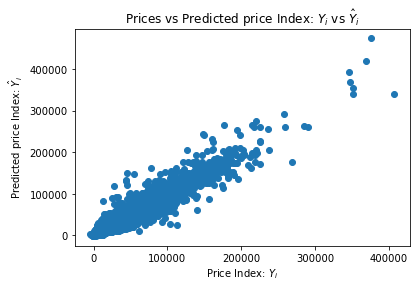

In [22]:
show_plot(tree, X_val, y_val)

### [2] RandomForest

In [23]:
forest = RandomForestRegressor(n_estimators=150, max_depth=45, max_features=8, min_samples_split=2, min_samples_leaf=1)
forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=45, max_features=8, n_estimators=150)

In [26]:
forest.score(X_val, y_val)

0.9797147461579785

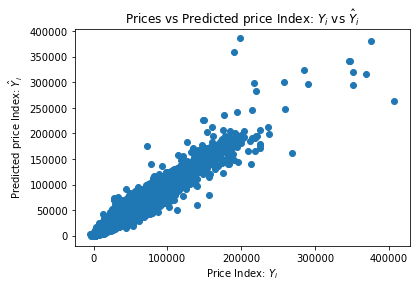

In [27]:
show_plot(forest, X_val, y_val)

### [3] XGBoost

In [28]:
xgb = XGBRegressor()

xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
xgb.score(X_val, y_val)

0.9514921753903859

### [4] KNeighborsRegressor

In [30]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [31]:
result = evaluation(knn, X_train, y_train, X_val, y_val)
print("Cross val score: " + str(result[0]))
print("R^2 score: " + str(result[1]))
print("Mean Absolute Erro: " + str(result[2]))

Cross val score: 0.7525924633789192
R^2 score: 0.6901845951064844
Mean Absolute Erro: 5642.085188960314


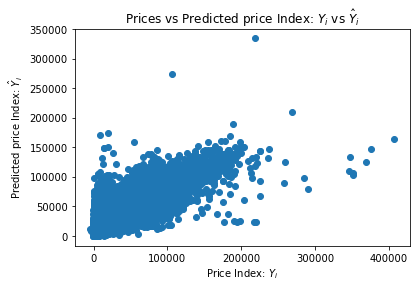

In [32]:
show_plot(knn, X_val, y_val)

### TEST 결과보기